In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib as mpt
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.transforms as mtransforms
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
mpt.rcParams['figure.dpi'] = 300

In [4]:
def BarPlot(file):
    '''
    Inputs: file: name of the real network;
    Outputs: freq.keys()/keys: list of curvature values, freq.values()/values: list of curvature's frequency, h (or 1): difference between two mean curvature values
    ''' 
    path = '../Data/Real_Networks/'
    BECvalue = pd.read_csv(path + f'{file}/{file}_BakryEmery_node.txt', sep = '\t', header = None)
    lf = len(BECvalue)
    frequency = Counter(BECvalue.iloc[:,1].round(0))
    keys, values = zip(*frequency.items())
    if file not in  ['Euroroad','ContiguousUSA']:
        freq = {}
        a, b = max(keys),min(keys)
        h = (a-b)/15
        k = []
        for i in range(15):
            k = list(set([j for j in keys if j <= a-i*h and j >= a-(i+1)*h])-set(k))
            v = sum([frequency[m] for m in k])
            freq[a-i*h-h/2] = v
        return freq.keys(),freq.values(),h
    return keys, values,1


### Distribution of Bakry-Émery-Ricci curvature

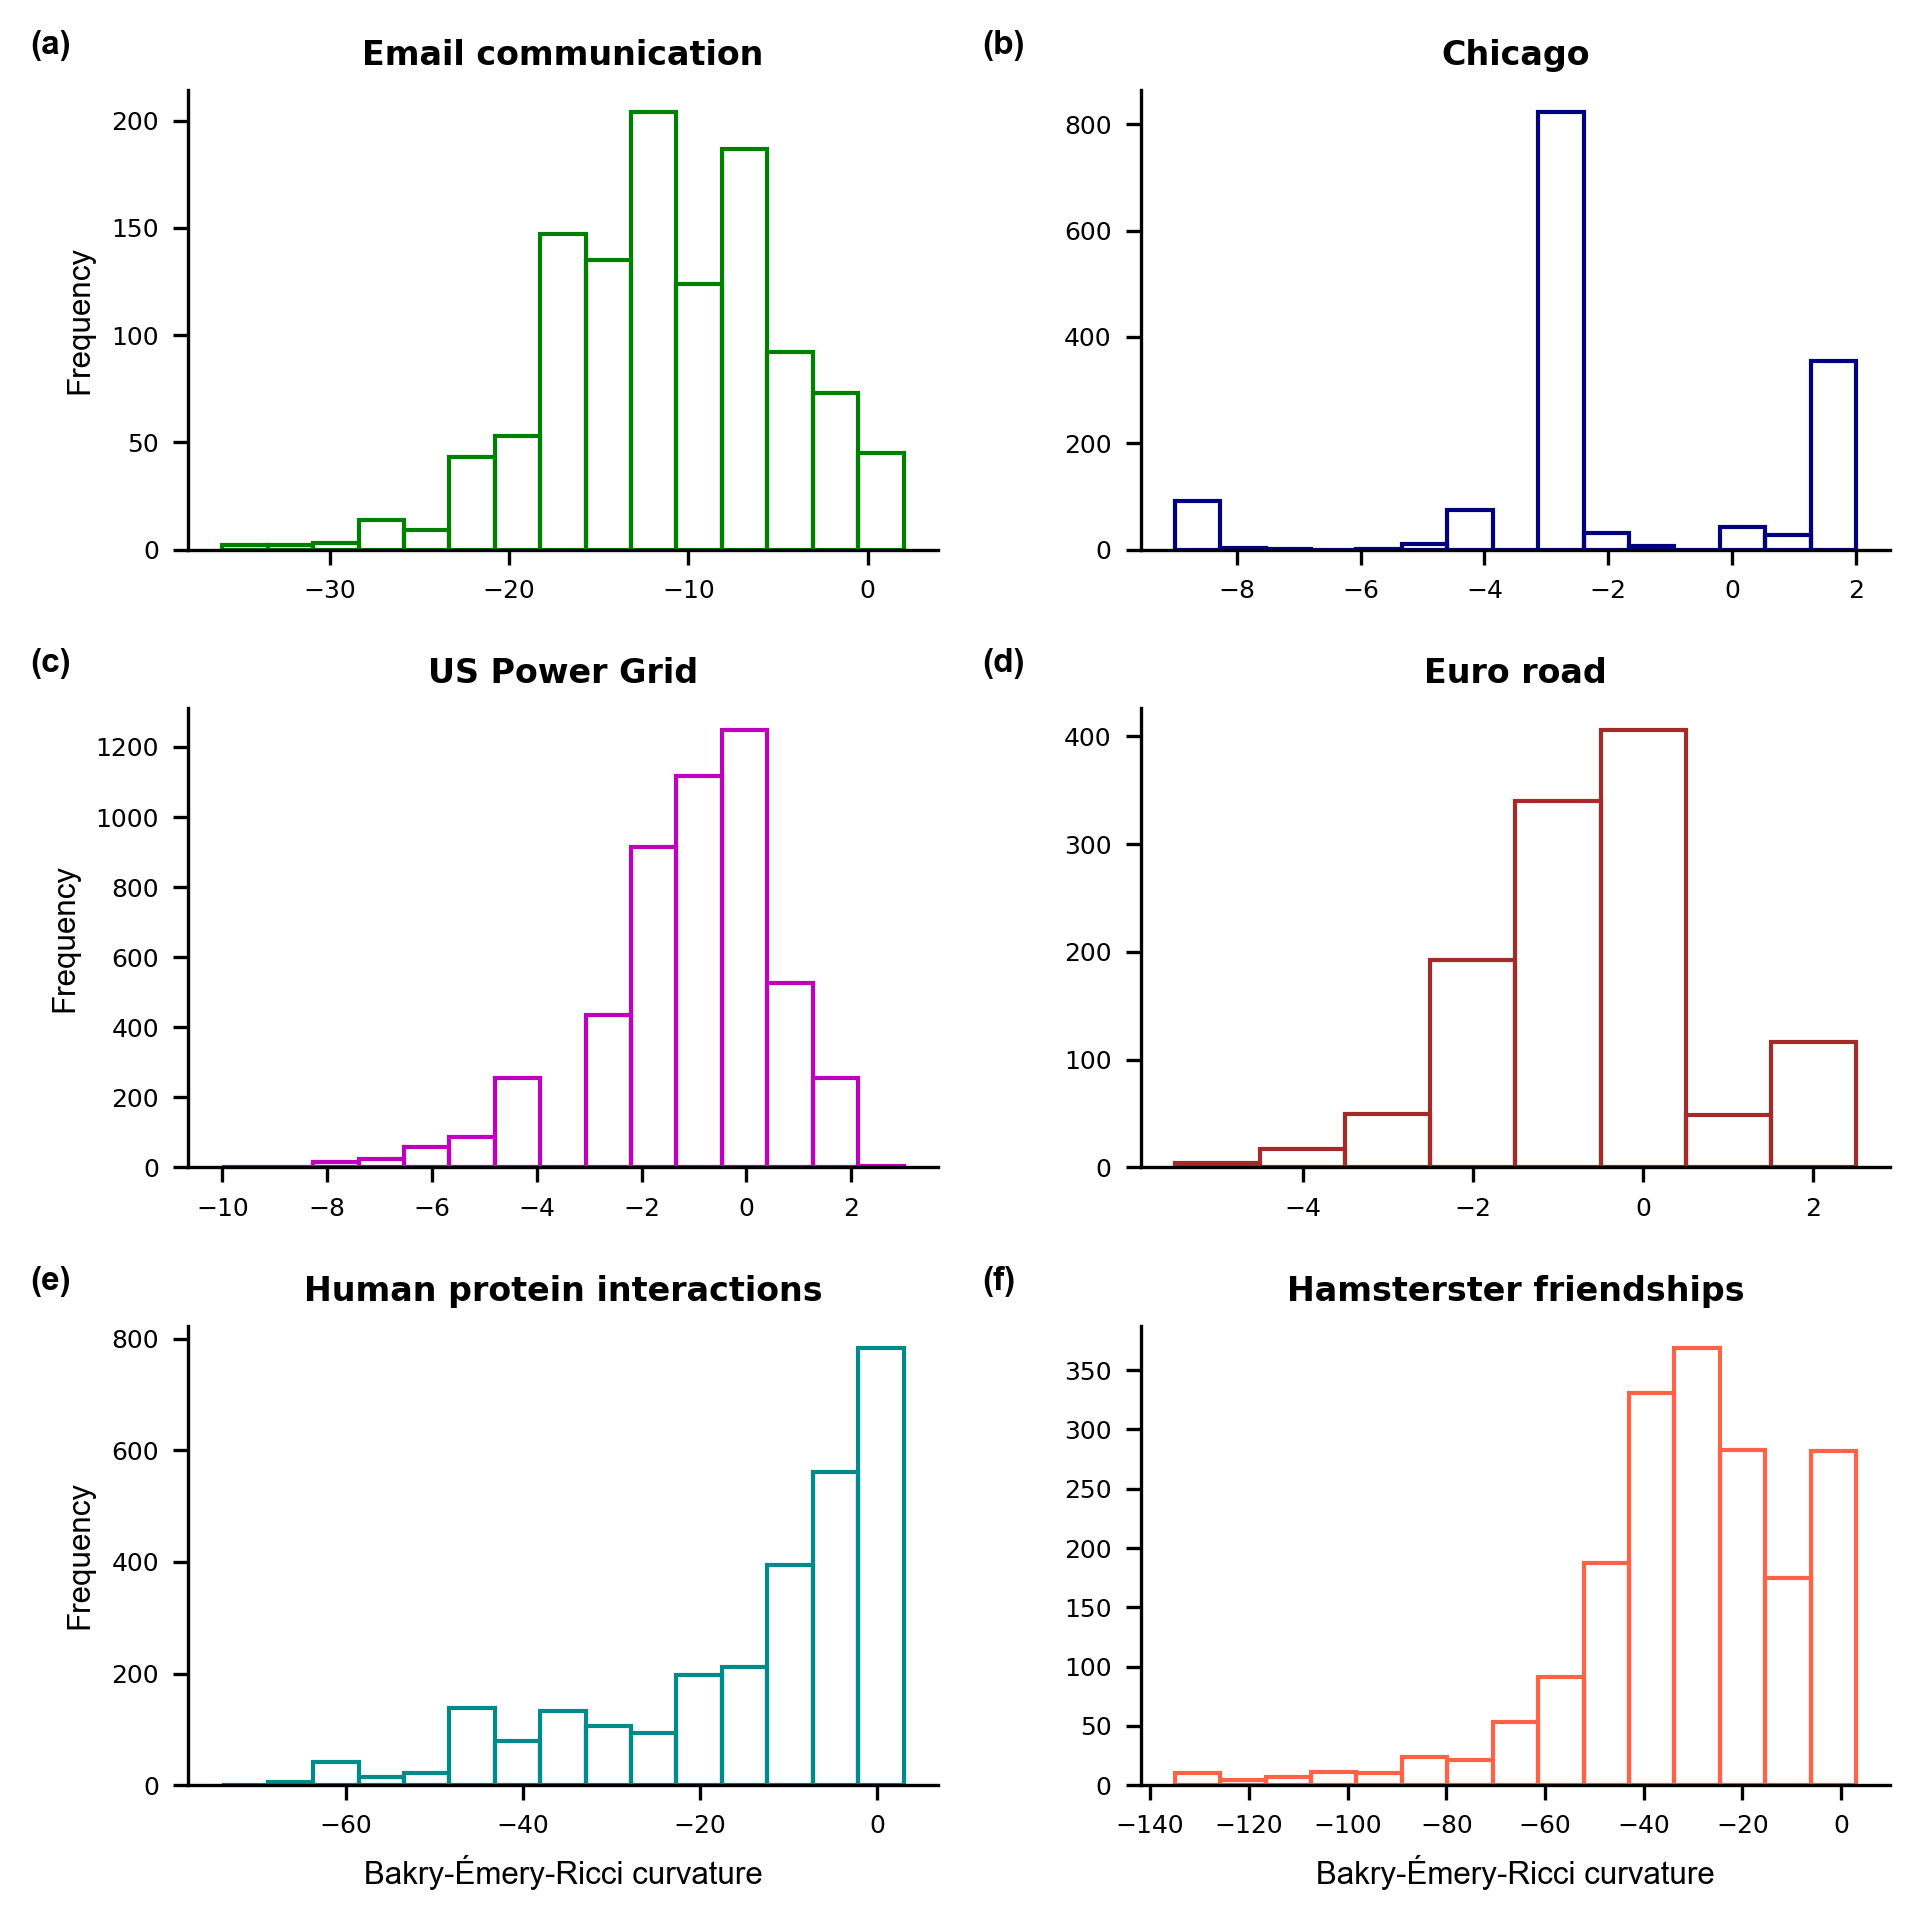

In [5]:
#-------------------------------------------------------------------------------
# Distribution of Bakry-Emery Curvature for real-world networks
#-------------------------------------------------------------------------------

fig, axes = plt.subplots(3, 2, figsize = (6.5,6.5),layout= 'tight')
labels = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)']
colours = ['g','navy','m','brown','darkcyan','tomato']
networks = ['ArenasEmail', 'Chicago', 'USPowerGrid', 'Euroroad', 'HumanProteinInteractions', 'HamstersterFriendships' ]
titles = ['Email communication','Chicago road', 'US Power Grid', 'Euro road', 'Human protein interactions','Hamsterster friendships' ]


for i, (ax, file, title, c, label) in enumerate(zip(axes.flatten(), networks, titles, colours,labels)):
    plot = BarPlot(file)
    ax.set_title(title, size = 8, loc = 'center', weight = 'bold')
    ax.spines[['right', 'top']].set_visible(False)
    ax.bar(plot[0],plot[1], width= plot[2], fill = False, edgecolor = c)
    ax.tick_params(axis='both', labelsize=6)
    ax.locator_params(axis='both', nbins=8)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(-0.1, 1.0, label, transform=ax.transAxes + trans,fontsize=8, va='bottom', fontfamily='Arial',weight='bold')
    if i in [4,5]:
        ax.set_xlabel('Bakry-Émery-Ricci curvature',fontname="Arial", size = 7.5) 
    if i in [0,2,4,6]: 
        ax.set_ylabel('Frequency', fontname="Arial", size = 7.5)
 
             
plt.savefig(f'../Figures/BEC_Distribution_real.pdf',dpi = 600)

In [6]:
#---------------------------------------------------------------------------------------
# Calculates Spearman Correlation between BakryEmery and other measures
#---------------------------------------------------------------------------------------
path = '../Data/Real_Networks/'

def correlation(file,measure):
    '''
    inputs: file: network name, measure: name of the another measure
    output: spear: Spearman correlation of the network between Bakry-Emery and another measure
    '''
    df = pd.read_csv(path + f'{file}/Correlation/{file}_corr_BakryEmery&{measure}_nodelcc.txt', sep = '\t', header = None)
    set1 = list(df[0])
    set2 = list(df[1])
    spear, p = stats.spearmanr(set1, set2)
    return spear


### Heatmap of correlation between Bakry-Émery-Ricci curvature and other measures

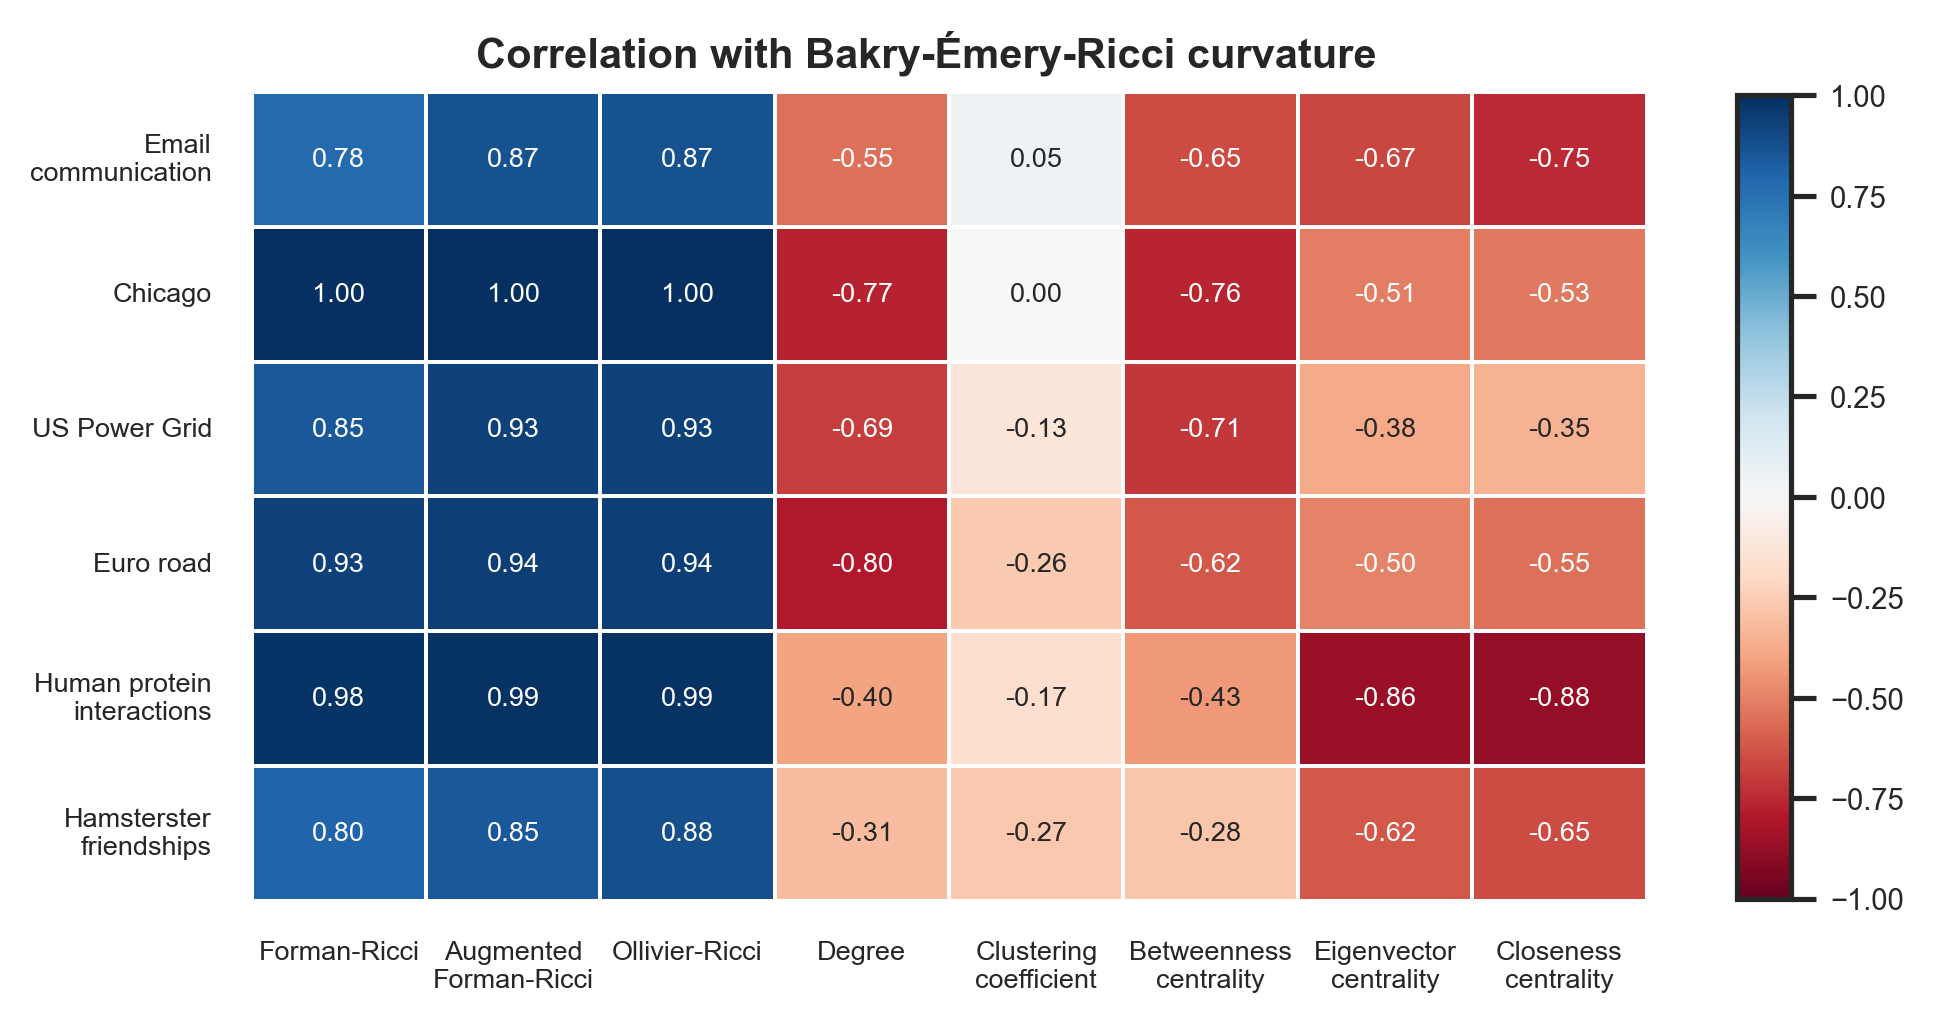

In [36]:
Graph_measure = ['Degree', 'ClusteringCoefficient','BetweennessCentrality','EigenVectorCentrality','ClosenessCentrality']
Curv_measure = ['Forman','AugForman','Ollivier'] 
all_measures = Curv_measure + Graph_measure

networks = ['ArenasEmail', 'Chicago', 'USPowerGrid', 'Euroroad', 'HumanProteinInteractions', 'HamstersterFriendships' ]
path = '../Data/Real_Networks/'

df = pd.DataFrame()
for file in networks:
    corrlist = []
    for m in all_measures:
        corr = correlation(file,m)
        corrlist.append(round(corr,2))
    df[file]=corrlist
    
df = df.fillna(0)
#print(df)


fig = plt.figure(figsize=(6,3.5))
sns.set_style("white")

#xlabels = ['FRC','AFRC','ORC','D','CC','BC','EC','CNC']
xlabels = ['Forman-Ricci','Augmented\nForman-Ricci','Ollivier-Ricci','Degree','Clustering\ncoefficient',
           'Betweenness\ncentrality','Eigenvector\ncentrality','Closeness\ncentrality']
ylabels = ['Email\ncommunication','Chicago road', 'US Power Grid', 'Euro road', 'Human protein\ninteractions','Hamsterster\nfriendships' ]
sns.heatmap(df.T,annot=True, annot_kws={'size':6.5}, fmt='.2f',xticklabels=xlabels, cmap = 'RdBu', yticklabels=ylabels,
                 vmax=1, vmin=-1, linewidth=.5,cbar = False)

plt.xticks(fontsize=6.5, rotation=0)
plt.yticks(fontsize=6.5)
ax.set_yticklabels(ax.get_yticklabels(), fontname='Arial',fontsize=15)
cb_ax = fig.add_axes([0.95, 0.112, 0.03, 0.765])
cmap = sns.color_palette("RdBu", as_cmap=True)
norm = mpt.colors.Normalize(vmin=-1, vmax=1)
cbar = fig.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cb_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=7)

plt.suptitle('Correlation with Bakry-Émery-Ricci curvature', fontname="Arial",y=0.94, fontweight='bold', fontsize=10)
plt.savefig(f'../Figures/Correlation_BEC_heatmap_real.pdf',dpi = 600,bbox_inches='tight')
plt.show()
sns.set_style("ticks")

### Robustness of the networks under vertices removal

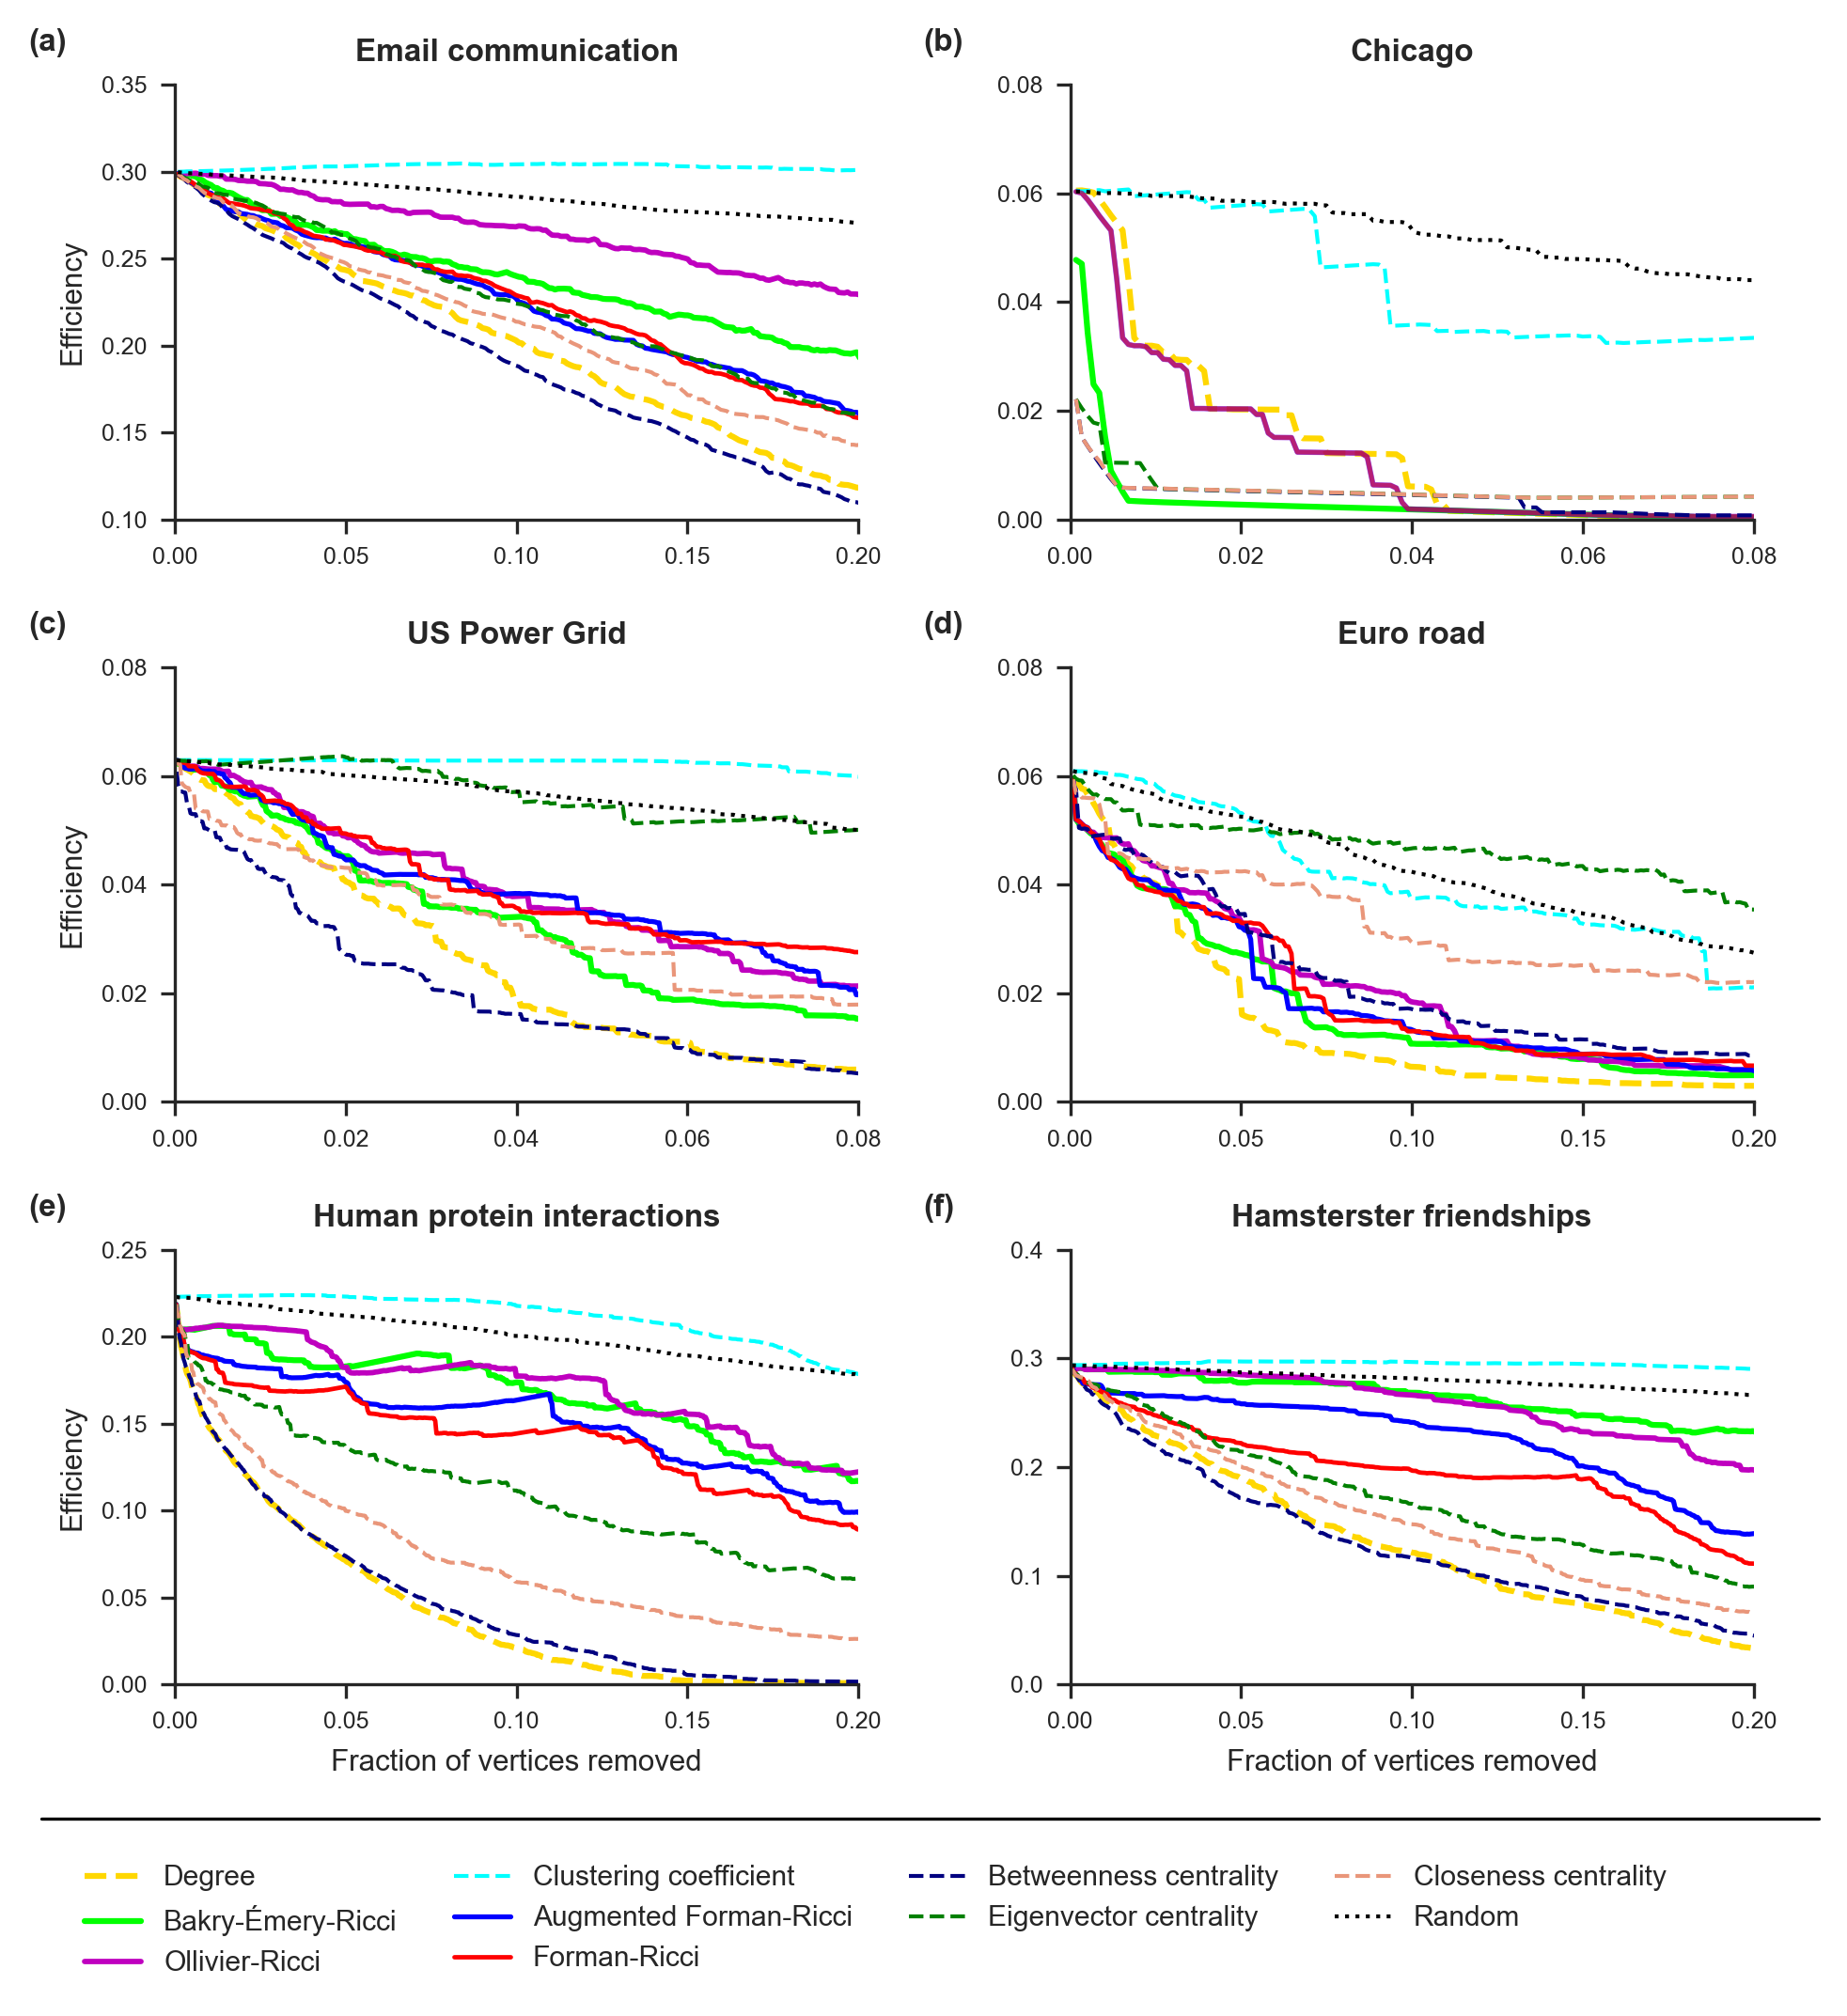

In [8]:
# Define a custom sorting function
def custom_sort(item):
    for m in Orders:
        if m in item:
            return Orders.index(m)
    return len(Orders)

fig, axes = plt.subplots(3, 2, figsize=(6.5, 6.5), layout= 'tight')

Orders = ['Degree','BakryEmery','Ollivier','ClusteringCoefficient','AugForman','Forman','BetweennessCentrality',
          'EigenVectorCentrality','ClosenessCentrality','Random']
linestyle = ['--','-','-','--','-','-','--','--','--',':']
networks = ['ArenasEmail', 'Chicago', 'USPowerGrid', 'Euroroad', 'HumanProteinInteractions', 'HamstersterFriendships' ]
titles = ['Email communication','Chicago road', 'US Power Grid', 'Euro road', 'Human protein interactions','Hamsterster friendships' ]
labels = ['(a)','(b)','(c)','(d)','(e)','(f)']
 

for i, (ax, network, title, label) in enumerate(zip(axes.flatten(), networks, titles, labels )):
    path = '../Data/Real_Networks/'
    path = path + f'{network}/Robustness/'
    dire1 = [i for i in os.listdir(path)]
    dire2 = sorted(dire1, key=custom_sort)
    colours = ['gold','lime','m','cyan','b','r','navy','g','DarkSalmon','black']
    no = 0
    lw = ['1.5,1.4,1.15,1']
    #print(network)
    for name,c,ls in zip(dire2, colours, linestyle):
        alpha=1
        file = pd.read_csv(path + name, sep = '\t')
        if 'Degree' in name: #model == 'HGG' and
            linewidth = 1.5
        elif ls != '-' :#or 'AugForman' in name:
            linewidth = 1
        else:    
            linewidth = 1.5-(0.12*no) #linewidth=1.2-0.08*colours.index(c)
            no +=1
        if network == 'Chicago' and ls == '-' and 'BakryEmery' not in name:
            alpha=0.5
        #print(name,linewidth,alpha) 
        ax.plot(file['Fraction_of_nodes'], file['Efficiency'], label = name, color = c, linestyle = ls, linewidth=linewidth,alpha=alpha)
    ax.set_title(title,loc = 'center', fontname="Arial", size = 8,weight='bold')
    ax.spines[['right', 'top']].set_visible(False) 
    ax.locator_params(axis='both', nbins=6)
    ax.tick_params(axis='both', labelsize=6)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(-0.1, 1.0, label, transform=ax.transAxes + trans,fontsize=8, va='bottom', fontfamily='Arial',weight='bold')
    if i in [4,5]:
        ax.set_xlabel('Fraction of vertices removed',fontfamily='Arial',size = 7.5)
    if i in [0,2,4]: 
        ax.set_ylabel('Efficiency', fontname="Arial", size = 7.5)
    ax.set_ylim(0,0.2)
    ax.set_xlim(0,0.2)
    if i in [1,2,3]:
        ax.set_xlim(0,0.08)
        ax.set_ylim(0,0.08)
    if i in [0,3,4,5]:
        ax.set_xlim(0,0.2)

axes[2,0].set_ylim(0,0.25)
axes[2,1].set_ylim(0,0.4)
axes[0,0].set_ylim(0.1,0.35)
 
n = ('Degree','Bakry-Émery-Ricci','Ollivier-Ricci','Clustering coefficient','Augmented Forman-Ricci','Forman-Ricci',
     'Betweenness centrality','Eigenvector centrality','Closeness centrality','Random')
fig.legend(n,loc="lower left",fontsize = 7.2, bbox_to_anchor=[0.04, -0.1], ncol = 4, edgecolor = 'w') 

line = plt.Line2D([0.03,1],[0,0], lw = 0.8, transform=fig.transFigure, color="black")
fig.add_artist(line)

plt.savefig(f'../Figures/Robustness_real.pdf', dpi = 600,bbox_inches='tight')
plt.show()

### Robustness of the networks under vertices removal based on $vertex_{min}$ and $vertex_{sum}$

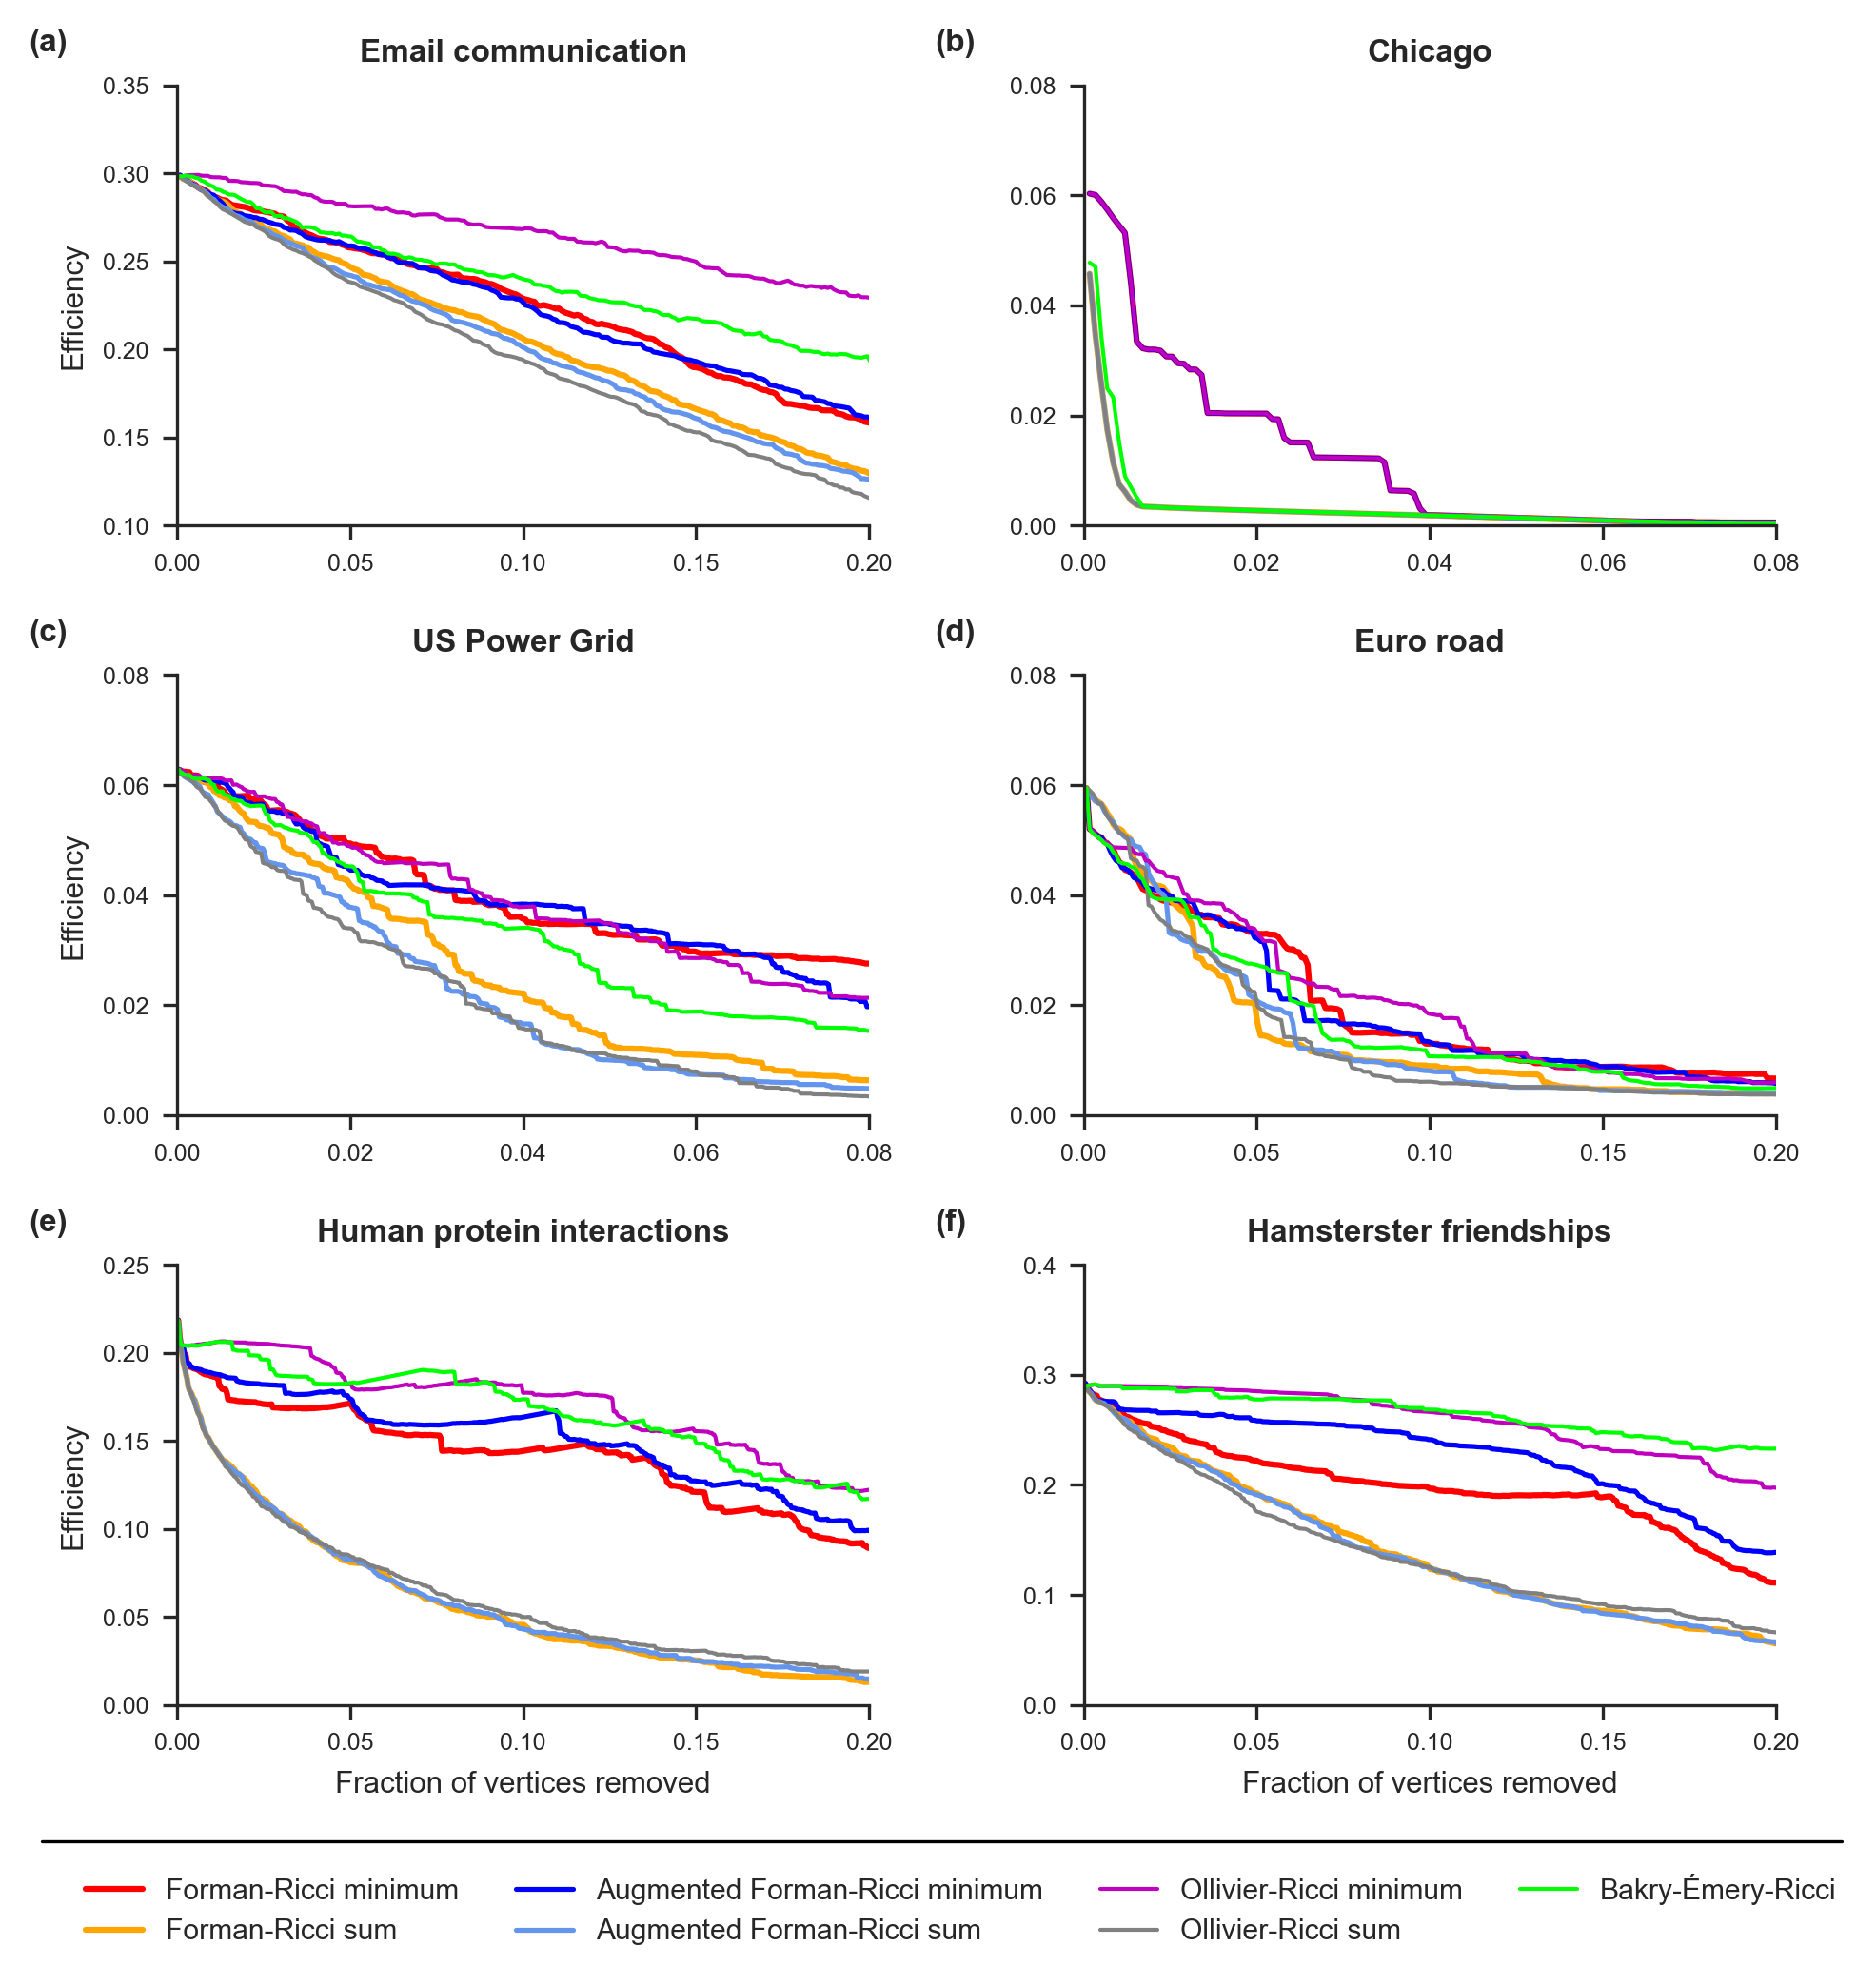

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(6.5, 6.5), layout= 'tight')

Orders = ['_Forman_min','_Forman_sum','AugForman_min','AugForman_sum','Ollivier_min','Ollivier_sum', 'BakryEmery']
networks = ['ArenasEmail', 'Chicago', 'USPowerGrid', 'Euroroad', 'HumanProteinInteractions', 'HamstersterFriendships' ]
titles = ['Email communication','Chicago road', 'US Power Grid', 'Euro road', 'Human protein interactions','Hamsterster friendships' ]
labels = ['(a)','(b)','(c)','(d)','(e)','(f)']
 

for i, (ax, network, title, label) in enumerate(zip(axes.flatten(), networks, titles, labels )):
    path = f'../Data/Real_Networks/{network}/Robustness_curv/'
    dire1 = [i for i in os.listdir(path)]
    dire2 = sorted(dire1, key=custom_sort)
    colours = ['r','orange','b','cornflowerblue','m','gray','lime']
    linewidth = [1.5,1.5,1.25,1.25,1,1,1]
    for name,c,lw in zip(dire2, colours, linewidth):
        file = pd.read_csv(path + name, sep = '\t')
        ax.plot(file['Fraction_of_nodes'], file['Efficiency'], label = name, linewidth=lw, color = c)
    ax.set_title(title,loc = 'center', fontname="Arial", size = 8,weight='bold')
    ax.spines[['right', 'top']].set_visible(False) 
    ax.locator_params(axis='both', nbins=6)
    ax.tick_params(axis='both', labelsize=6)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(-0.1, 1.0, label, transform=ax.transAxes + trans,fontsize=8, va='bottom', fontfamily='Arial',weight='bold')
    if i in [4,5]:
        ax.set_xlabel('Fraction of vertices removed',fontfamily='Arial',size = 7.5)
    if i in [0,2,4]: 
        ax.set_ylabel('Efficiency', fontname="Arial", size = 7.5)
    ax.set_ylim(0,0.2)
    ax.set_xlim(0,0.2)
    if i in [1,2,3]:
        ax.set_xlim(0,0.08)
        ax.set_ylim(0,0.08)
    if i in [0,3,4,5]:
        ax.set_xlim(0,0.2)

axes[2,0].set_ylim(0,0.25)
axes[2,1].set_ylim(0,0.4)
axes[0,0].set_ylim(0.1,0.35)

n = ('Forman-Ricci minimum','Forman-Ricci sum','Augmented Forman-Ricci minimum','Augmented Forman-Ricci sum',
     'Ollivier-Ricci minimum','Ollivier-Ricci sum', 'Bakry-Émery-Ricci')
fig.legend(n,loc="lower left",fontsize = 7.2, bbox_to_anchor=[0.04, -0.07], ncol = 4, edgecolor = 'w') 
line = plt.Line2D([0.03,1],[0,0], lw = 0.8, transform=fig.transFigure, color="black")
fig.add_artist(line)
plt.savefig(f'../Figures/Robustness_real_curv.pdf', dpi = 600,bbox_inches='tight')
plt.show()

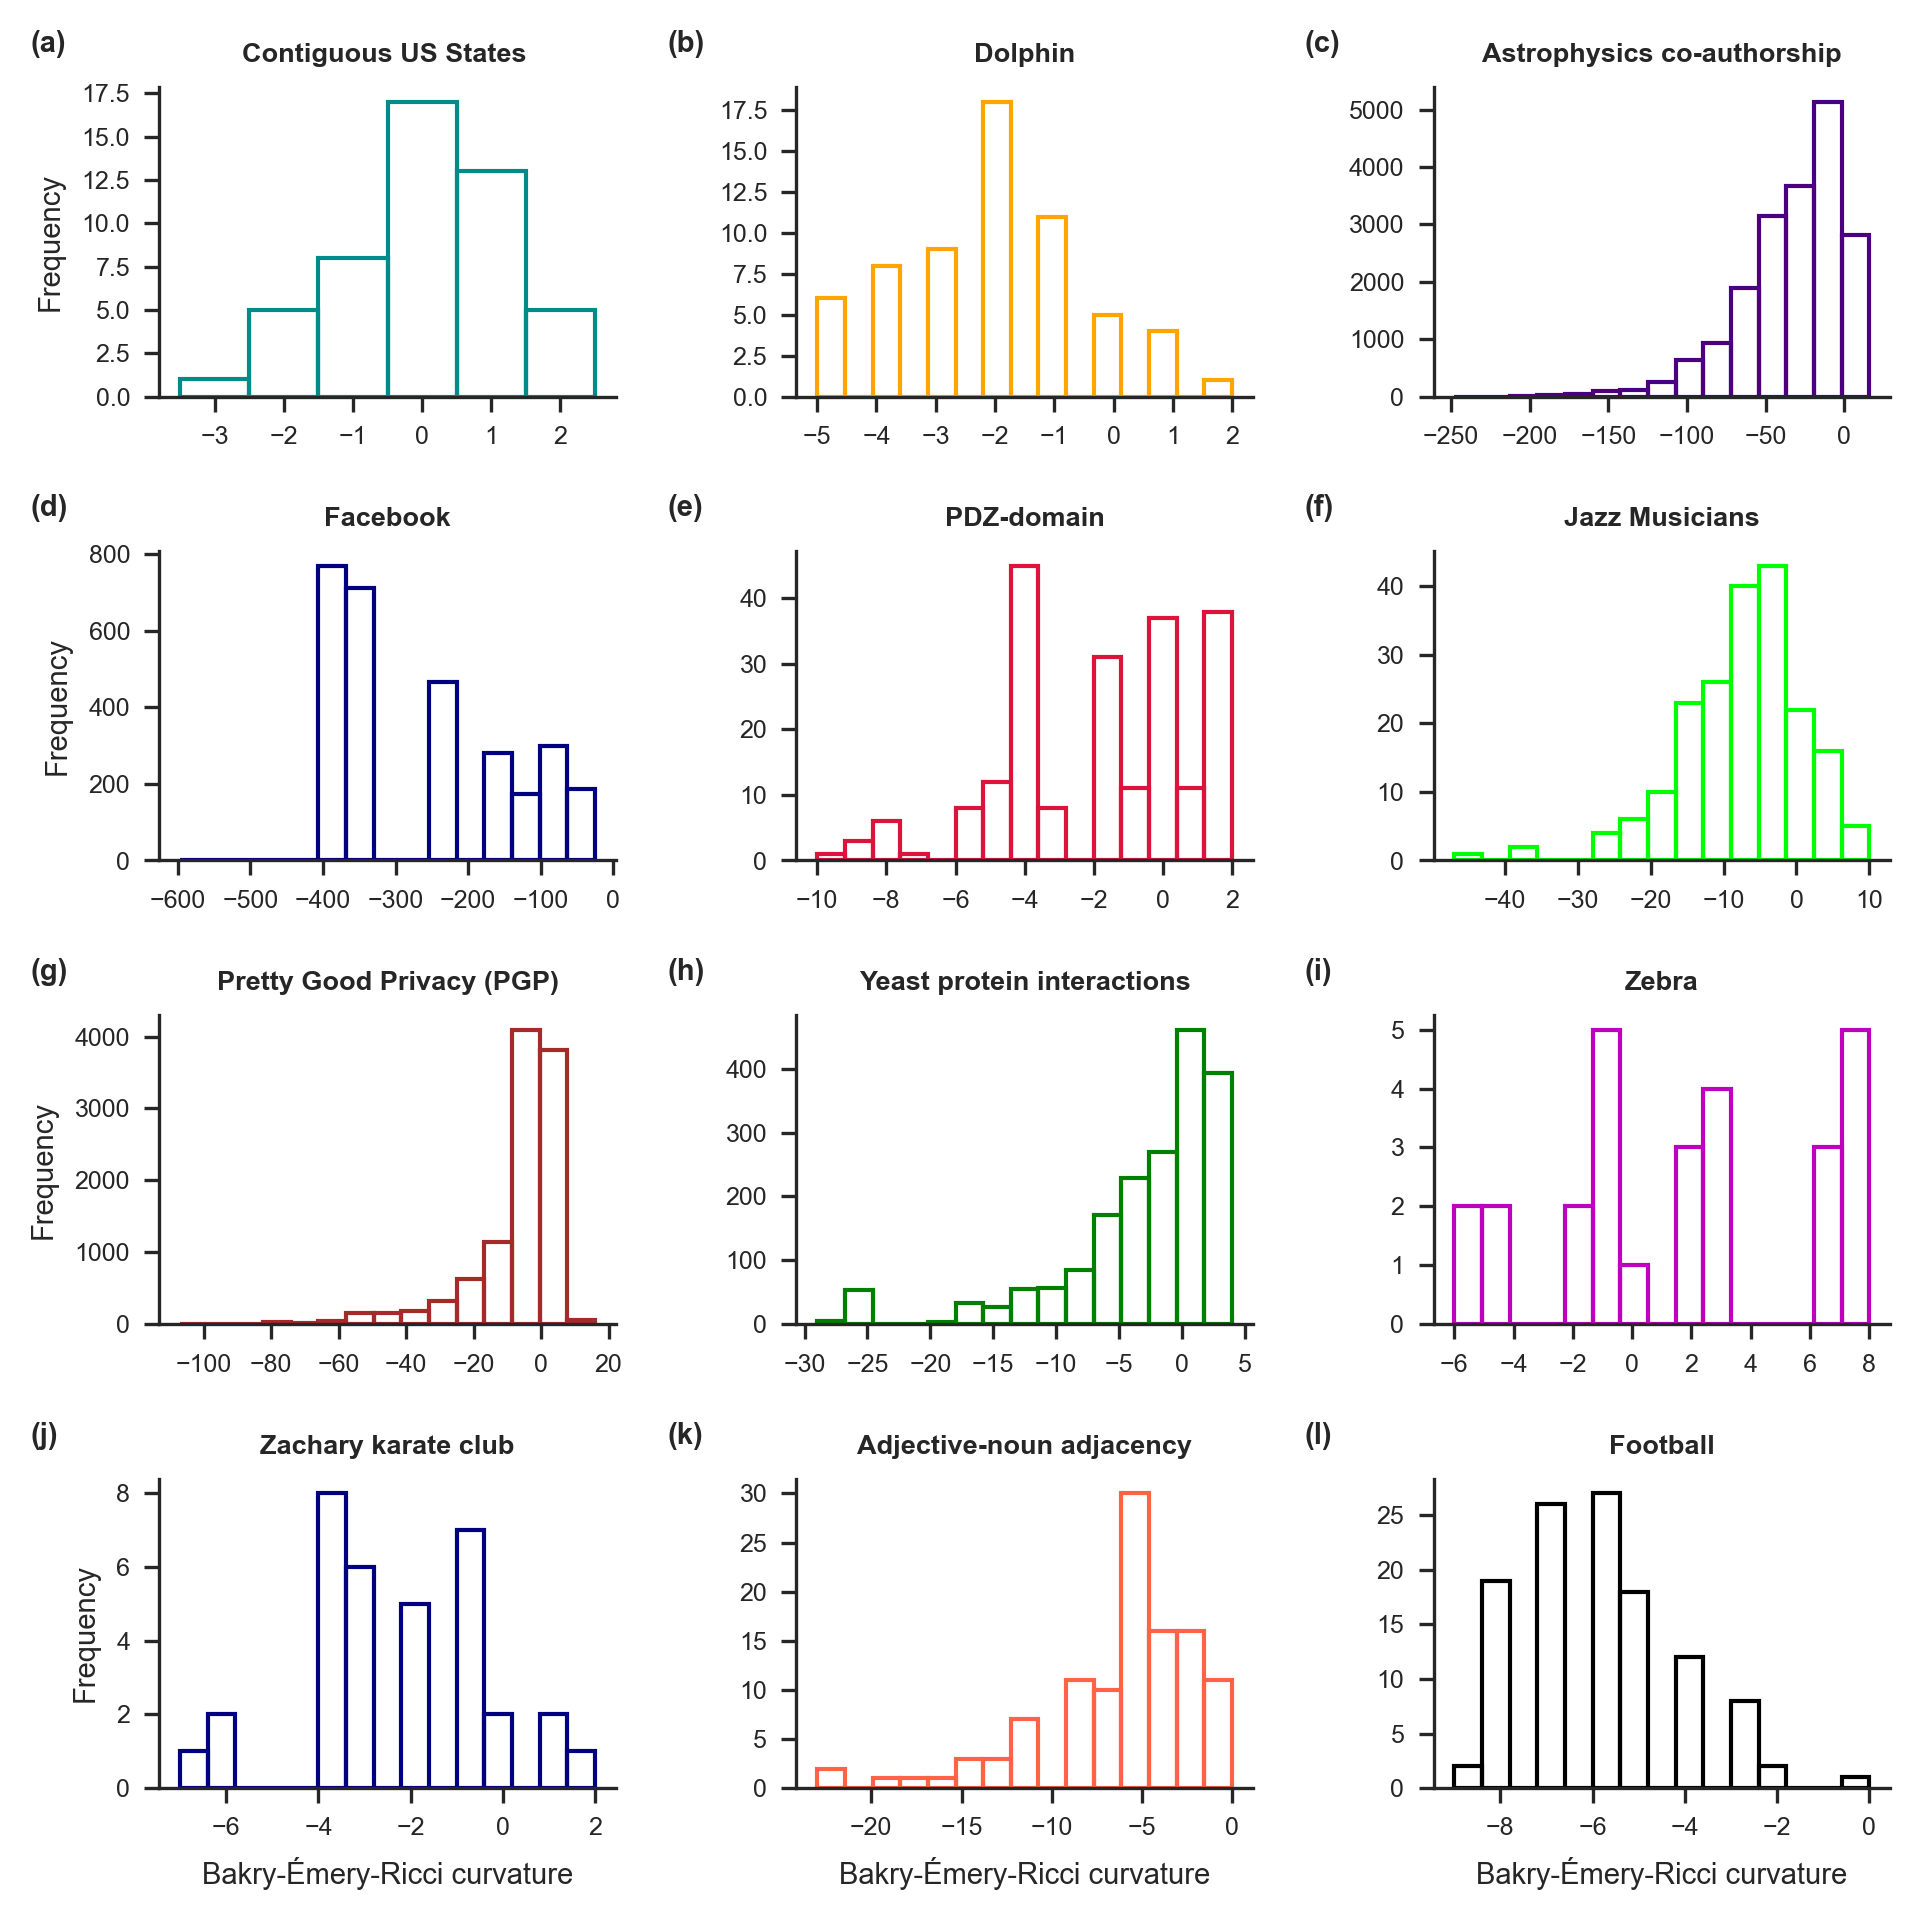

In [10]:
#-------------------------------------------------------------------------------
# Distribution of Bakry-Emery Curvature for real-world networks
#-------------------------------------------------------------------------------

fig, axes = plt.subplots(4, 3, figsize = (6.5,6.5),layout= 'tight')
networks = ['ContiguousUSA','Dolphins', 'arXivAstroPh','FacebookNIPS', 'PDZBase', 'JazzMusicians',  'PrettyGoodPrivacy', 
            'Protein', 'Zebra',  'ZacharyKarateClub', 'AdjNounAdjacency','dimacs10Football']
titles = ['Contiguous US States ','Dolphin', 'Astrophysics co-authorship','Facebook','PDZ-domain', 'Jazz Musicians', 
          'Pretty Good Privacy (PGP)', 'Yeast protein interactions','Zebra', 'Zachary karate club', 'Adjective-noun adjacency', 'Football']

labels = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
colours = ['darkcyan','orange','indigo','navy','crimson','lime','brown','g','m','navy','tomato','black']

for i, (ax, file, title, c, label) in enumerate(zip(axes.flatten(), networks, titles, colours,labels)):
    plot = BarPlot(file)
    ax.set_title(title, size = 6.5, loc = 'center', weight = 'bold')
    ax.spines[['right', 'top']].set_visible(False)
    ax.bar(plot[0],plot[1], width= plot[2], fill = False, edgecolor = c)
    ax.tick_params(axis='both', labelsize=6)
    ax.locator_params(axis='both', nbins=8)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(-0.1, 1.0, label, transform=ax.transAxes + trans,fontsize=7, va='bottom', fontfamily='Arial',weight='bold')
    if i in [9,10,11]:
        ax.set_xlabel('Bakry-Émery-Ricci curvature',fontname="Arial", size = 7) 
    if i in [0,3,6,9]: 
        ax.set_ylabel('Frequency', fontname="Arial", size = 7)
 
             
plt.savefig(f'../Figures/BEC_Distribution_real_SI.pdf',dpi = 600)